## TASK 2 - Image stitching

Group Number: 14

### 1. Data import and SIFT Extraction

Complete ***get_panorama_data(..)*** in _dataset.py_ to read the images and extract the SIFT keypoints and descriptors per image. Check your implementation by plotting the result using ***utils.plot_keypoints(..)***.


***Submission:*** Save the *second* image (from left) of the campus dataset as **task2_keypoints.png** using ***utils.plot_keypoints(..)***.

In [5]:
%load_ext autoreload
%autoreload 1
%aimport transforms, panorama, mapping, dataset, utils
import matplotlib.pyplot as plt
import numpy as np
import transforms
import panorama
import mapping
import dataset
import utils
import cv2

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 150

data_path = 'data/office_rot'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


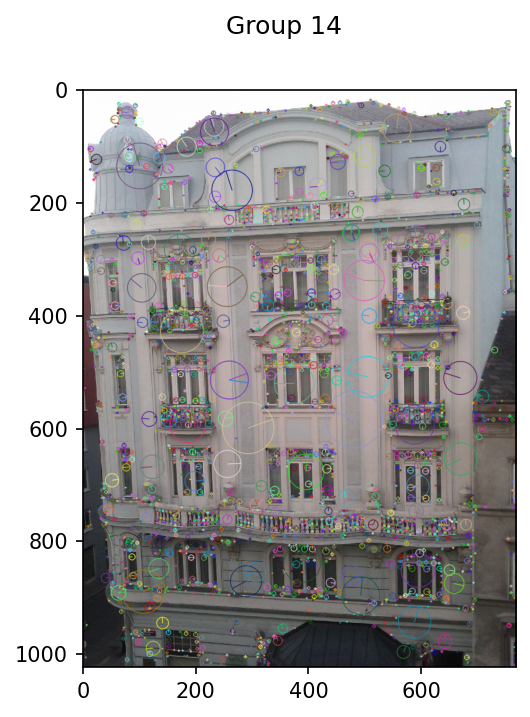

Number of images:  5
Keypoints length:  2204
Descriptor shape:  (2204, 128)


In [6]:
#student_code start
images, keypoints, descriptors = dataset.get_panorama_data(data_path)

second_img_index = 1
utils.plot_keypoints(images[second_img_index],
                     keypoints[second_img_index],
                     'Group 14',
                     'task2_keypoints.png')
#student_code end

# check import
print('Number of images: ',len(images))
print('Keypoints length: ', len(keypoints[0]))
print('Descriptor shape: ',descriptors[0].shape)

***
#### What is the meaning of the size of the drawn circles and lines inside the circles?

Answer:

The **circles** represent the positions of the keypoints.

The **size of each circle** corresponds to the scale of the keypoint. Bigger circles mark features that appear on larger patterns or structures in the image.

The **line inside each keypoint circle** represents its orientation, which corresponds to the main gradient direction around the point. This allows the keypoint descriptor to remain consistent even if the image is rotated.

#### 1.1 Matching

Let's take a look at the matching. Plot the matches between two adjacent images using ***mapping.calculate_matches(..)*** and ***utils.plot_matches(..)***.


***Submission:*** Save plot of matches between the *second and the third image* image of the campus dataset as **task2_matches.png** using ***utils.plot_matches(..)***.


In [ ]:

index1 = 1
index2 = 2

#student_code start
matches = mapping.calculate_matches(descriptors[index1], descriptors[index2])

utils.plot_matches(images[index1], images[index2], 
                   keypoints[index1], keypoints[index2], 
                   matches,
                   'Group 14',
                   'task2_matches.png')
#student_code end

***
#### Describe below how the matching, based on LOWE, works.

Answer:
The LOWE matching algorithmus is used to match local SIFT descriptors between two overlapping images of the same scene. The goal is to identify keypoints in image 1 that correspond to the same physical points in image 2.

1. For each detected keypoint in both images, a SIFT descriptor is computed. A descriptor is a 128 dimensional vector describing the local gradient structure around the keypoint.

2. To find potential correspondences, each descriptor from image 1 is compared against all descriptors in image 2 using euclidean distance. In our case: For each descriptor, the two nearest neighbours (k=2) in the second image are retrieved (matches = bf.knnMatch(desk1, desk2, k=2)).

3. Most false matches occur when different descriptors have very similar distances to a given descriptor. The LOWE ratio test solves the problem: A match is accepted only if the best match is significantly better than the second best. (m.distance / n.distance < 0.8). It removes the majority of incorrect correspondences becauce ambiguous matches are discarded.


### 2. Image Registration using RANSAC

As you can see in the keypoint matching plot above, the matching algorithm still has some wrong connections. To remove those outliers, you will implement RANSAC and use the remaining inliers to estimate a final tranformation matrix (homography) between two given images. Implement RANSAC in ***get_transform(..)*** in _transforms.py_.

Check your implementation by plotting the result using ***utils.plot_matches(..)***.


***Submission:*** Save a plot showing the matches between the *second and the third image* of the campus dataset again, using the calculated inliers, as **task2_matches_ransac.png** using ***utils.plot_matches(..)***.

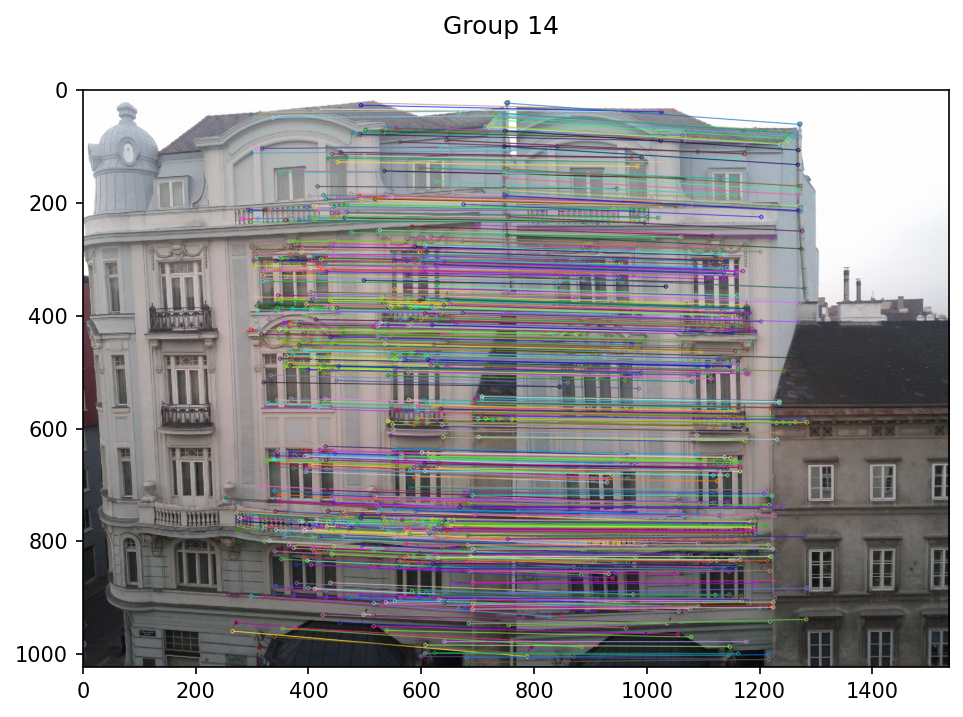

In [9]:

#student_code start
trans, inliers = transforms.get_transform(keypoints[index1], keypoints[index2], matches)

# Extract keypoints of inliers, because drawMatches needs correct inliers list as parameter
kp1_inliers = [keypoints[index1][matches[i].queryIdx] for i in inliers]
kp2_inliers = [keypoints[index2][matches[i].trainIdx] for i in inliers]

# Create new DMatch because indices is a reduced list of inliers
# In other words: Outliers are removed
inlier_matches = [cv2.DMatch(idx, idx, 0) for idx in range(len(inliers))] 

utils.plot_matches(images[index1], images[index2], 
                   kp1_inliers, kp2_inliers, 
                   inlier_matches,
                   'Group 14',
                   'task2_matches_ransac.png')
#student_code end

***
#### What is the difference to the set of all putative matches you plotted before?

Answer:
The set of putative matches conains all descriptor based correspondences including many outliers.

After applying RANSAC, only those matches remain that are geometrically consistent with a homography between two selected images. Thus, RANSAC removes the false matches.The RANSAC inliers is the subset of putative matches that satisfy the geometric constraint (homography).

Visually, the matches after RANSAC appear almost horizontally alligned. In contrast, the plot of all putative matches contains many criss-corssing and noisy connection lines. 

#### 2.1 Align Images

Test your homography after RANSAC by transforming a chosen image to the corresponding image on the right and plot with ***transforms.plot_transformed_image(..)***.

_***HINT:***_
_cv2.warpPerspective(..)_


***Submission:*** Save the second image of the campus dataset transformed onto the third one as **task2_matches_transformed.png** using ***utils.plot_transformed_image(..)***.

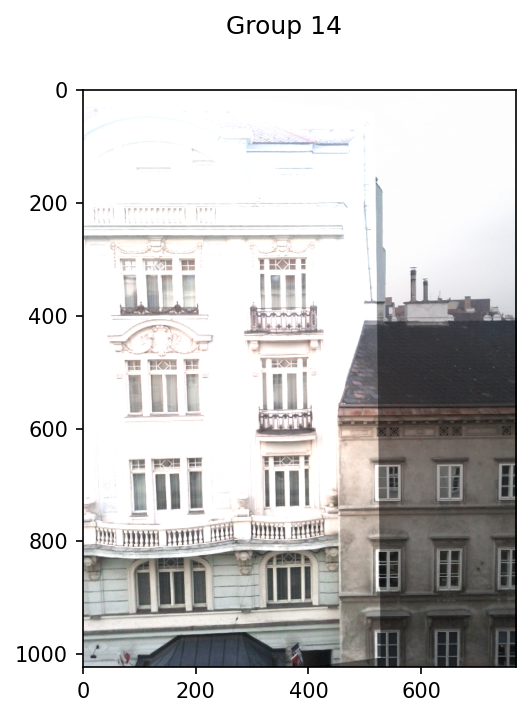

In [10]:
#student_code start
height, width, channel = images[index1].shape
transformed_image1 = cv2.warpPerspective(images[index1], trans, (width, height)) # transform second onto third image with H
utils.plot_transformed_image(transformed_image1, 
                             images[index2],
                             'Group 14', 
                             'task2_matches_transformed.png')
#student_code end

### 3. Image Stitching

Before, you implemented the basics to calculated homographies between two images. Further, transform all images to a reference image, usually the center one, to get a balanced panorama. Implement and use the method ***to_center(..)*** in _transforms.py_ to get all homographies to the center image.


In [ ]:
#student_code start

#student_code end

#### Panorama Extents

One final step before panorama composition is to estimate the final panorama size based on the obtained homographies. Implement ***transforms.get_panorama_extents(..)***

In [ ]:
#student_code start



#student_code end

print("Panorama dimension: ", height, " ",width)

#### Simple Panorama  

Here is where the magic happens. Using the homographies, translation matrix and panorama extents, you can now stitch the images to a panorama. Implement ***panorama.get_simple(..)*** and check your result with ***utils.plot_panorama(..)***.

***Submission:*** Save the campus panorama as **task2_panorama_simple.png** using ***utils.plot_panorama(..)***.

In [ ]:
#student_code start

#student_code end

### 4. Panorama Feathering

The simple panorama might look geometrically correct, but not pleasant enough yet. The intensities are simply stacked. Implement a color blending method to improve the panorama output. 

Complete ***panorama.get_blended(..)*** and check your result with ***utils.plot_panorama(..)***.

***Submission:*** Save the improved blended campus panorama as **task2_panorama_blended.png** using ***utils.plot_panorama(..)***.

In [ ]:
#student_code start

#student_code end


***
#### Compare the result achieved with feathering to the result where no blending has been performed. What is the difference of the two results?

#ANSWER HERE

***
#### Examine if the presented scheme of SIFT interest point detection and RANSAC-based alignment is invariant to changes in image rotation and scale. Thus, resize and rotate the second image of the campus dataset and repeat the panorama process. What do you observe?

***Submission:*** Save the resulting panorama with the rotated images as file ***panorama_rotated_blended.png*** (feathered)

#ANSWER HERE

***
#### Once again, repeat the panorama procedure with your own image sequence. Save and discuss the achieved results. The result might look quite realistic at a first glance but can you spot any errors by looking on details?

***Submission:*** Save the resulting panorama as file ***panorama_own.png*** (feathered) 

#ANSWER HERE